##### **Name: Mubanga Nsofu, Learner Id: 149050** <br>
##### **Email: mnsofu@learner.nexford.org** <br>
##### **Course: BAN6440, Week 5, Milestone Assignment 2**<br>
##### **Institution: Nexford University**<br>
##### **Lecturer: Professor Bucciarelli** <br>
##### **Date: 7th December, 2024** <br>
##### **Task: MD Anderson Cancer Institute Cancer Diagnosis using ANNs**

-------------------------------------
##### ***Introduction***

In this milestone assignment, we will build an Artificial Neural Network (ANN) model using the high-level Keras API within the TensorFlow framework. The goal of this ANN is to predict cancer diagnoses. Given that the dataset contains diagnoses categorized as either benign or malignant, this is a binary classification problem. The dataset can be found on Kaggle.


----------------------------------------------
 ##### ***Step 1: Import The Necessary Libraries***


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # data visualization
from sklearn.model_selection import train_test_split # Splits the data in test and training sets
from sklearn.model_selection import StratifiedKFold  # K-Fold Cross-Validation
from sklearn.preprocessing import StandardScaler  # Normalizes the data
from sklearn.metrics import accuracy_score, classification_report # Model evaluation
import tensorflow as tf  # Tensorflow API
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import  l1,l2  # Import regularizers
from tkinter import Tk # For a GUI dialog box to select the dataset
from tkinter.filedialog import askopenfilename
import sweetviz as sv # For automated exploratory data analysis (EDA)

tf.keras.utils.set_random_seed(812)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

----------------------------------------------
##### ***Step 2: Download The dataset from Kaggle***


Download dataset from here  https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data 

-------------------------------------------------------------------------------------------
##### ***Step 3: Define Function to select the downloaded file***  


In [2]:
# This function allows the user to select the downloaded file using a tkinter diaglong box.


def load_file():
    """
    Open a file dialog for the user to select a CSV or *.zip file, ensuring the dialog appears in the foreground.

    Returns:
    - file_path (str): The full path of the selected file.
    """
    # Create a hidden Tkinter root window
    root = Tk()
    root.withdraw()  # Hide the main Tkinter window

    # Bring the file dialog to the front
    root.attributes("-topmost", True)
    file_path = askopenfilename(
        title="Select a File",
        filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
    )
    root.destroy()  # Destroy the hidden root window after use
    
    if not file_path:
        raise FileNotFoundError("No file selected. Please select a CSV file.")
    
    return file_path




------------------------------------------------------------------
##### ***Step 4: Perform Exploratory Data Analysis (EDA) using SweetViz Library***   


In [3]:
# Perform EDA with Sweetviz
# When running this line a GUI will open up, ensure you select file type to all as the downloaded file is called archive.zip

def perform_eda(file_path):
    """
    Perform Exploratory Data Analysis (EDA) using Sweetviz.

    Parameters:
    - file_path (str): Path to the dataset CSV or zip file.

    Returns:
    - None: Displays the EDA report in a web browser.
    """
    # Load the dataset
    data = pd.read_csv(file_path)
    
    # Create a Sweetviz report
    report = sv.analyze(data)
    
    # Save the report as an HTML file and display it
    report.show_html("EDA_Report.html")
    print("EDA report generated: EDA_Report.html")

# Dynamically load the file and perform EDA
file_path = load_file()  # Use the previously defined load_file function
perform_eda(file_path)


Done! Use 'show' commands to display/save.   |█| [100%]   00:02 -> (00:00 left)

Report EDA_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
EDA report generated: EDA_Report.html


The EDA report has several important insights. 
- The dataset has 569 observations, no duplicates, with 33 features ( 1 categorical, 31 numerical and 1 Text). 
- For the text values numerical encoding will be applied.
- There is a column called *Unnamed:32*. It has all values missing. This will be removed.
- There is an unnecessary column called id.
- There is also class imbalance in the dataset for the diagnosis feature. This will be taken into account using SMOTE.
- The report also shows the associations between the different features.
- The dataset has feature values with different magnitudes. Normalization will be applied to scale the data.
- An html file is generated in the working directory

------------------------------------------------------------------
##### ***Step 5: Clean the data***   



In [4]:
data = pd.read_csv(file_path)
data = data.drop(columns=["id", "Unnamed: 32"]) # Drop "id" and "Unnamed" columns



data


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


------------------------------------------------------------------
##### ***Step 6: Encode the diagnosis feature to numeric***   


In [5]:
data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})

data


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


------------------------------------------------------------------
##### **Step 7: Feature and Target Separation**   


In [6]:
X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

------------------------------------------------------------------
##### **Step 8: Split the training and test sets**   


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


------------------------------------------------------------------
##### **Step 9: Normalize the dataset**   


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------------------------------------------
##### ***Step 10: Define And Compile The ANN Model***   



In [9]:
def create_model():
    model = Sequential([
    Dense(16, kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),  # L2 regularization
    LeakyReLU(alpha=0.1),  # Leaky ReLU
    Dropout(0.1),
    Dense(8, kernel_regularizer=l2(0.0001)),  # L2 regularization
    LeakyReLU(alpha=0.1),  # Leaky ReLU 
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



--------------------------------------------
##### ***Step 11: Train and Test The ANN Model***

In [10]:
print("Training and evaluating model...")
model = create_model()
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=0)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

Training and evaluating model...


C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


#### Model Summary is shown below

In [11]:
model.summary()

Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼─────────────────────

> The model has a total of 1925 parameters 

-----------------------------------------
##### ***Step 12: Evaluate the Model Performance***

> Plot of the model loss during the training

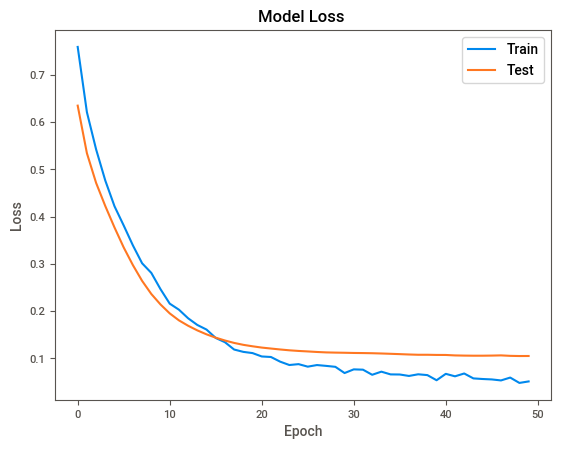

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [13]:
print(f"Test Accuracy: {accuracy:.2f}, loss:{loss:.2f}")


Test Accuracy: 0.97, loss:0.07


> The model achieved an accuracy of 97%, with a loss of 7%. Accuracy score measures the ratio of correctly classified instances to the total.

> Training an ANN is a stochastic process and each run typically generates different results unless a seed is applied. To ensure model stability a more pragmatic approach is chosen later on which invloves evluating model performance over multiple iterations, this is discussed later on.

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        71
           1       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



The metrics above are discussed below.

> **1. Precision:** Precision is the proportion of correctly predicted True observations of the total predicted positives. $(True Positives)/ (True Positives + False Positives)$
- Benign (class 0) has a precision of 99%, indicating that 99% of the samples predicted as Benign were correct.
- Malignant (class 1) has a precision of 95%, indicating that 95% of the samples predicted as Malignant were correct.
- **Precision Analysis:** The model is highly precise in predicting both benign and malignant cases, especially benign cases. <br>

> **2. Recall (Sensitivity):** This is the ratio of correctly predicted positive observations to all actual positives
$(True Positives)/(True Positives + False Negatives)$

 - Benign (class 0) has a recall of 97%, indicating that the model correctly identified all of actual Benign cases.
 - Malignant (class 1) has a recall of 98%, indicating that the model correctly identified 98% of actual Malignant cases.
 - **Sensitivity Analysis:** The model is slightly better at identifying benign cases than malignant cases, with a strong abaility to detect both. <br>

 > **3. F1-Score:** F1 score is the harmonic mean of precision and recall, balancing both metrics. 
 $Recall/(Recall + Precision)$

- Benign (class 0) has an F1-Score of 98%
- Malignant (class 1) has an F1-Score of 97%
- **F1 Score Analysis:** both values indicate good model performance for both classes with slightly better performance for benign cases <br>

> **4. Support:** This is the number of true instances for each class in the dataset.
- Benign (class 0) : There are 71 benign cases in the test set
- Malignant (class 1) : There are 43 malignant cases in the test set
- **Support Analysis:** the test set has more benign than malignant cases indicating class imbalance. This could influence the overall metrics and care must be taken to deal with this.

> **Overall Metrics:**

- Accuracy:The model correctly classified 97% of all cases.
- Macro Average: is the average of both classes' precision, recall and F1-score equally. The model's precision is 97%, the recall is 97%, and the F1-score is 97%.
- Weighted Average: The metrics averages are weighted by the number of samples in each class. The weighted Averages for all three metrics (Precision, Recall, and F1-Score) are 98%, respectively.

> **Overall Metric Analysis:** The model performs well, maintaining balanced metrics for benign and malignant cases. However, since recall for malignant cases is crucial in medical applications to minimise false negatives (missed malignant cases), and a recall of 95% is strong, further enhancements to recall could improve diagnostic accuracy.

------------------------------------------------------
#### **Key Insights**

- The model is highly accurate (97%) and precise, with excellent recall and F1 Scores for both classes. However, recall for malignant cases is crucial in medical applications to minimise false negatives (missed malignant cases), and although a recall of 95% is strong, further enhancements to recall could improve diagnostic accuracy.

- The model will be enhanced to ensure better detection of malignant cases, minimizing false negatives.

------------------------------------------------------------------
##### ***Step 13: Strategies to Improve Malignant Detection***   

> Class imbalance was identified during the EDA phase, in addition, each run of the model generates different accuracy scores, this will now be addressed using **K-Fold Cross- Validation** to help estimate the skill of the model as it is stochastic.

In [15]:
# K-Fold Cross-Validation
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

accuracies = [] # To store accuracies for each fold
losses = [] # To store losses for each fold
fold_reports = []  # To store classification reports for each fold
fold_losses = []  # To store training loss for each fold
fold_val_losses = [] # To store validation loss for each fold

for fold, (train_index, test_index) in enumerate(kf.split(X, y), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

------------------------------
##### ***Step 14: Train the model with 5-Fold Cross Validation***

In [16]:
# Train and evaluate model
model = create_model()
history = model.fit(X_train, y_train, validation_data= (X_test,y_test),epochs=50, batch_size=32, verbose=0)

# Store training loss
fold_losses.append(history.history['loss'])
fold_val_losses.append(history.history['val_loss'])

# Predict only for the fold-specific test set
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Ensure the shapes match
assert len(y_pred) == len(y_test), "Mismatch between prediction and test set sizes."


loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracies.append(accuracy)
losses.append(loss)
print(f"Fold accuracy: {accuracy:.2f},loss:{loss:.2f}")

C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold accuracy: 0.99,loss:0.04


> The model achieved an accuracy of 99%, with a loss of 4%. Accuracy score measures the ratio of correctly classified instances to the total.

--------------------
##### ***Step 15: Evaluate the Model***

In [17]:
# Evaluate model and store results
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

# Generate and store classification report
report = classification_report(y_test, y_pred, target_names=["Benign", "Malignant"])
fold_reports.append(f"Fold {fold}:\n{report}")
print(f"Fold {fold} Accuracy: {accuracy:.2f}")

# Display overall performance
print("\nCross-Validation Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.2f}")
print(f"Standard Deviation: {np.std(accuracies):.2f}\n")

# Print classification reports for all folds
for report in fold_reports:
    print(report)

Fold 5 Accuracy: 0.99

Cross-Validation Results:
Mean Accuracy: 0.99
Standard Deviation: 0.00

Fold 5:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        71
   Malignant       1.00      0.98      0.99        42

    accuracy                           0.99       113
   macro avg       0.99      0.99      0.99       113
weighted avg       0.99      0.99      0.99       113



The metrics above are discussed below.

> **1. Precision:** Precision is the proportion of correctly predicted True observations of the total predicted positives. $(True Positives)/ (True Positives + False Positives)$
- Benign (class 0) has a precision of 99%, indicating that 99% of the samples predicted as Benign were correct.
- Malignant (class 1) has a precision of 100%, indicating that all of the samples predicted as Malignant were correct.
- **Precision Analysis:** The model is highly precise in predicting both benign and malignant cases. <br>

> **2. Recall (Sensitivity):** This is the ratio of correctly predicted positive observations to all actual positives
$(True Positives)/(True Positives + False Negatives)$

 - Benign (class 0) has a recall of 100%, indicating that the model correctly identified 100% of actual Benign cases.
 - Malignant (class 1) has a recall of 99%, indicating that the model correctly identified 99% of actual Malignant cases.
 - **Sensitivity Analysis:** The model is slightly better at identifying benign cases than malignant cases, with a strong abaility to detect both. <br>

 > **3. F1-Score:** F1 score is the harmonic mean of precision and recall, balancing both metrics. 
 $Recall/(Recall + Precision)$

- Benign (class 0) has an F1-Score of 99%
- Malignant (class 1) has an F1-Score of 99%
- **F1 Score Analysis:** both values indicate good model performance for both classes with slightly better performance for benign cases <br>

> **4. Support:** This is the number of true instances for each class in the dataset.
- Benign (class 0) : There are 71 benign cases in the test set
- Malignant (class 1) : There are 42 malignant cases in the test set
- **Support Analysis:** the test set has more benign than malignant cases indicating class imbalance. This could influence the overall metrics and care must be taken to deal with this.

> **Overall Metrics:**

- Accuracy:The model correctly classified 99% of all cases.
- Macro Average: is the average of both classes' precision, recall and F1-score equally. The model's precision is 99%, the recall is 99%, and the F1-score is 99%.
- Weighted Average: The metrics averages are weighted by the number of samples in each class. The weighted Averages for all three metrics (Precision, Recall, and F1-Score) are 99%, respectively.

> **Overall Metric Analysis:** The model performs well, maintaining balanced metrics for benign and malignant cases. Recall for malignant cases has now improved from 95% to 98% which is crucial in medical applications to minimise false negatives (missed malignant cases), improving diagnostic accuracy.

--------------------------
##### ***Step 16: Visualise Training and Validation Losses***

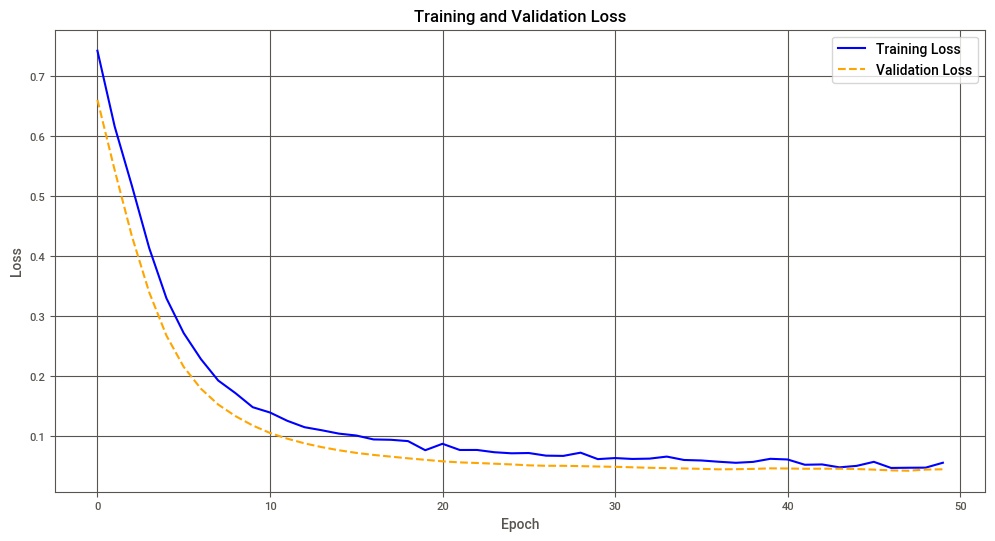

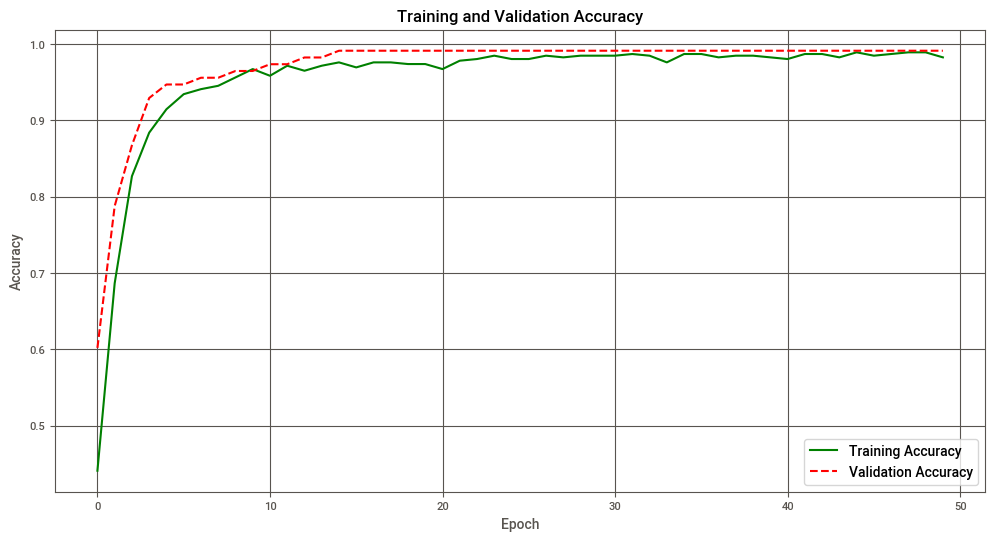

In [51]:
# Extracting data
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(loss, label="Training Loss", color="blue")
plt.plot(val_loss, label="Validation Loss", color="orange", linestyle="--")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label="Training Accuracy", color="green")
plt.plot(val_accuracy, label="Validation Accuracy", color="red", linestyle="--")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

> The training and validation loss Plot shows the ANN model is able to generalize well on the test set indicating robustness

> The Validation Accuracy performance is better than that of the training set indicating the model is able to generalize well.

------------------------------------------------------------------
##### ***Step 17: Conclusion***  


> ANNs can be used to learn complex relationships in tabular data. In this assignment, ANNs have been used to classify Malignant and Benign tumours for MD Anderson Cancer Institute. The model's mean Accuracy is 99% with a Precision of 100% and Recall of 98% for Malignant Cases.

> In the future, Computer Vision will be considered as another way to classify images.

----------------------------------------------
##### **References**



Tran, K. A., Kondrashova, O., Bradley, A., Williams, E. D., Pearson, J. v., & Waddell, N. (2021). Deep learning in cancer diagnosis, prognosis and treatment selection. Genome Medicine, 13(1), 152. https://doi.org/10.1186/s13073-021-00968-x


google. (n.d.). Keras: The high-level API for TensorFlow | TensorFlow Core. Retrieved December 9, 2024, from https://www.tensorflow.org/guide/keras


Kaul, S. (2024). Building Deep Learning Models with Keras: A Step-by-Step Guide with Code Examples. Medium. https://medium.com/@sumit.kaul.87/building-deep-learning-models-with-keras-a-step-by-step-guide-with-code-examples-68aee4152625

